# Model Tuning

Author: Valentina Staneva

This notebook discusses techniques to improve the performance of a model: particularly in the case where we do not have a lot of training data and the models can be prone to overfitting. It covers several strategies:

* Dropout
* Data Augmentation
* Tranfer Learning

Along the way we will also go through details on

* Optimization
* Monitoring Performance
* Loading and Saving Models

This notebook is built on these sources:

* [*Tensorflow Classification Tutorial*](https://www.tensorflow.org/tutorials/images/classification)

* [*Transfer Learning with VGG16 and Keras*](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4),  Medium Blog Post by Gabriel Cassimiro

* [*Tensorflow Transfer Learning Tutorial*](https://www.tensorflow.org/tutorials/images/transfer_learning)

## Setup

Import TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# set random seed
# tf.keras.utils.set_random_seed(123)

## Flowers Dataset

This tutorial uses a [dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) of about 3,700 photos of flowers. The dataset contains five types of flowers:

```
  daisy
  dandelion
  roses
  sunflowers
  tulips
```

The goal is to build a classifier which predicts the type of flowers in new images.

The dataset is part of a collection of [datasets](https://www.tensorflow.org/datasets) in the `tensorflow` library which can be directly loaded.

In [3]:
# downloading images

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')


image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [4]:
# the images are arranged in folders with their names
import os
list(os.walk(data_dir))[0]

('/home/studio-lab-user/.keras/datasets/flower_photos',
 ['roses', 'sunflowers', 'tulips', 'daisy', 'dandelion'],
 ['LICENSE.txt'])

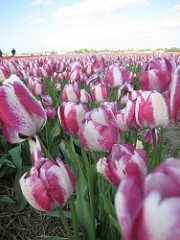

In [5]:
# looking at a few tulips
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

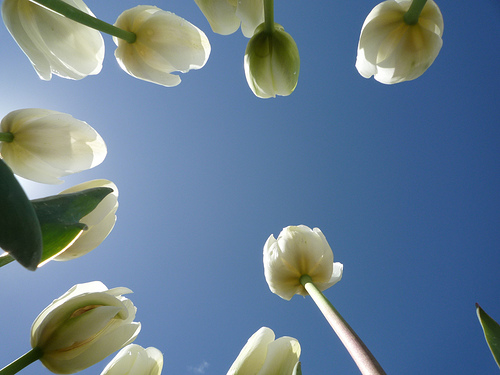

In [6]:
PIL.Image.open(str(tulips[1]))

#### Images are not the same size!

The images in the dataset are not the same size so we will resize them so that it is easier to put them in an array and process them efficiently. We fix the weight and height to be 150. This resizing can be achieved automatically while reading the data with the `tf.keras.utils.image_dataset_from_directory` function and setting the image size.

In [7]:
HEIGHT = 150
WIDTH = 150

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  labels="inferred",
  label_mode="categorical",
  seed=123,
  image_size=(HEIGHT, WIDTH),
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  labels="inferred",
  label_mode="categorical",
  seed=123,
  image_size=(HEIGHT, WIDTH),
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Hold Out Test Set
Not we set aside 20% for a test set which we will NOT use in model training and selection. It is easy to overtune the model performance to the specific test we have selected and because we have no more "unseen" data to test on our measures of performance may be skewed. We will only use the test set in the end to evaluate the performance on "unseen" data.

In [9]:
# convert to numpy arrays
train_images, train_labels = zip(*list(train_ds.unbatch()))
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [10]:
print(train_images.shape)
print(train_labels.shape)

(2936, 150, 150, 3)
(2936, 5)


We loaded the labels in a categorical format, but we also need the class names. These correspond to the directory names in alphabetical order.

In [11]:
class_names = ["daisy", "dandelion", "roses", "sunflowers","tulips"]
num_classes = len(class_names)

Let's see the distribution of the classes:

<BarContainer object of 5 artists>

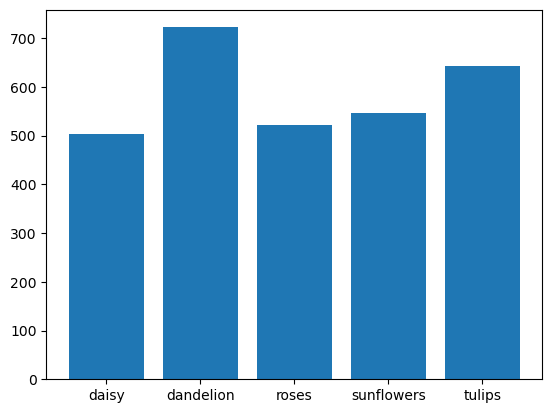

In [12]:
plt.bar(class_names, train_labels.sum(axis=0))

### Visualize the data



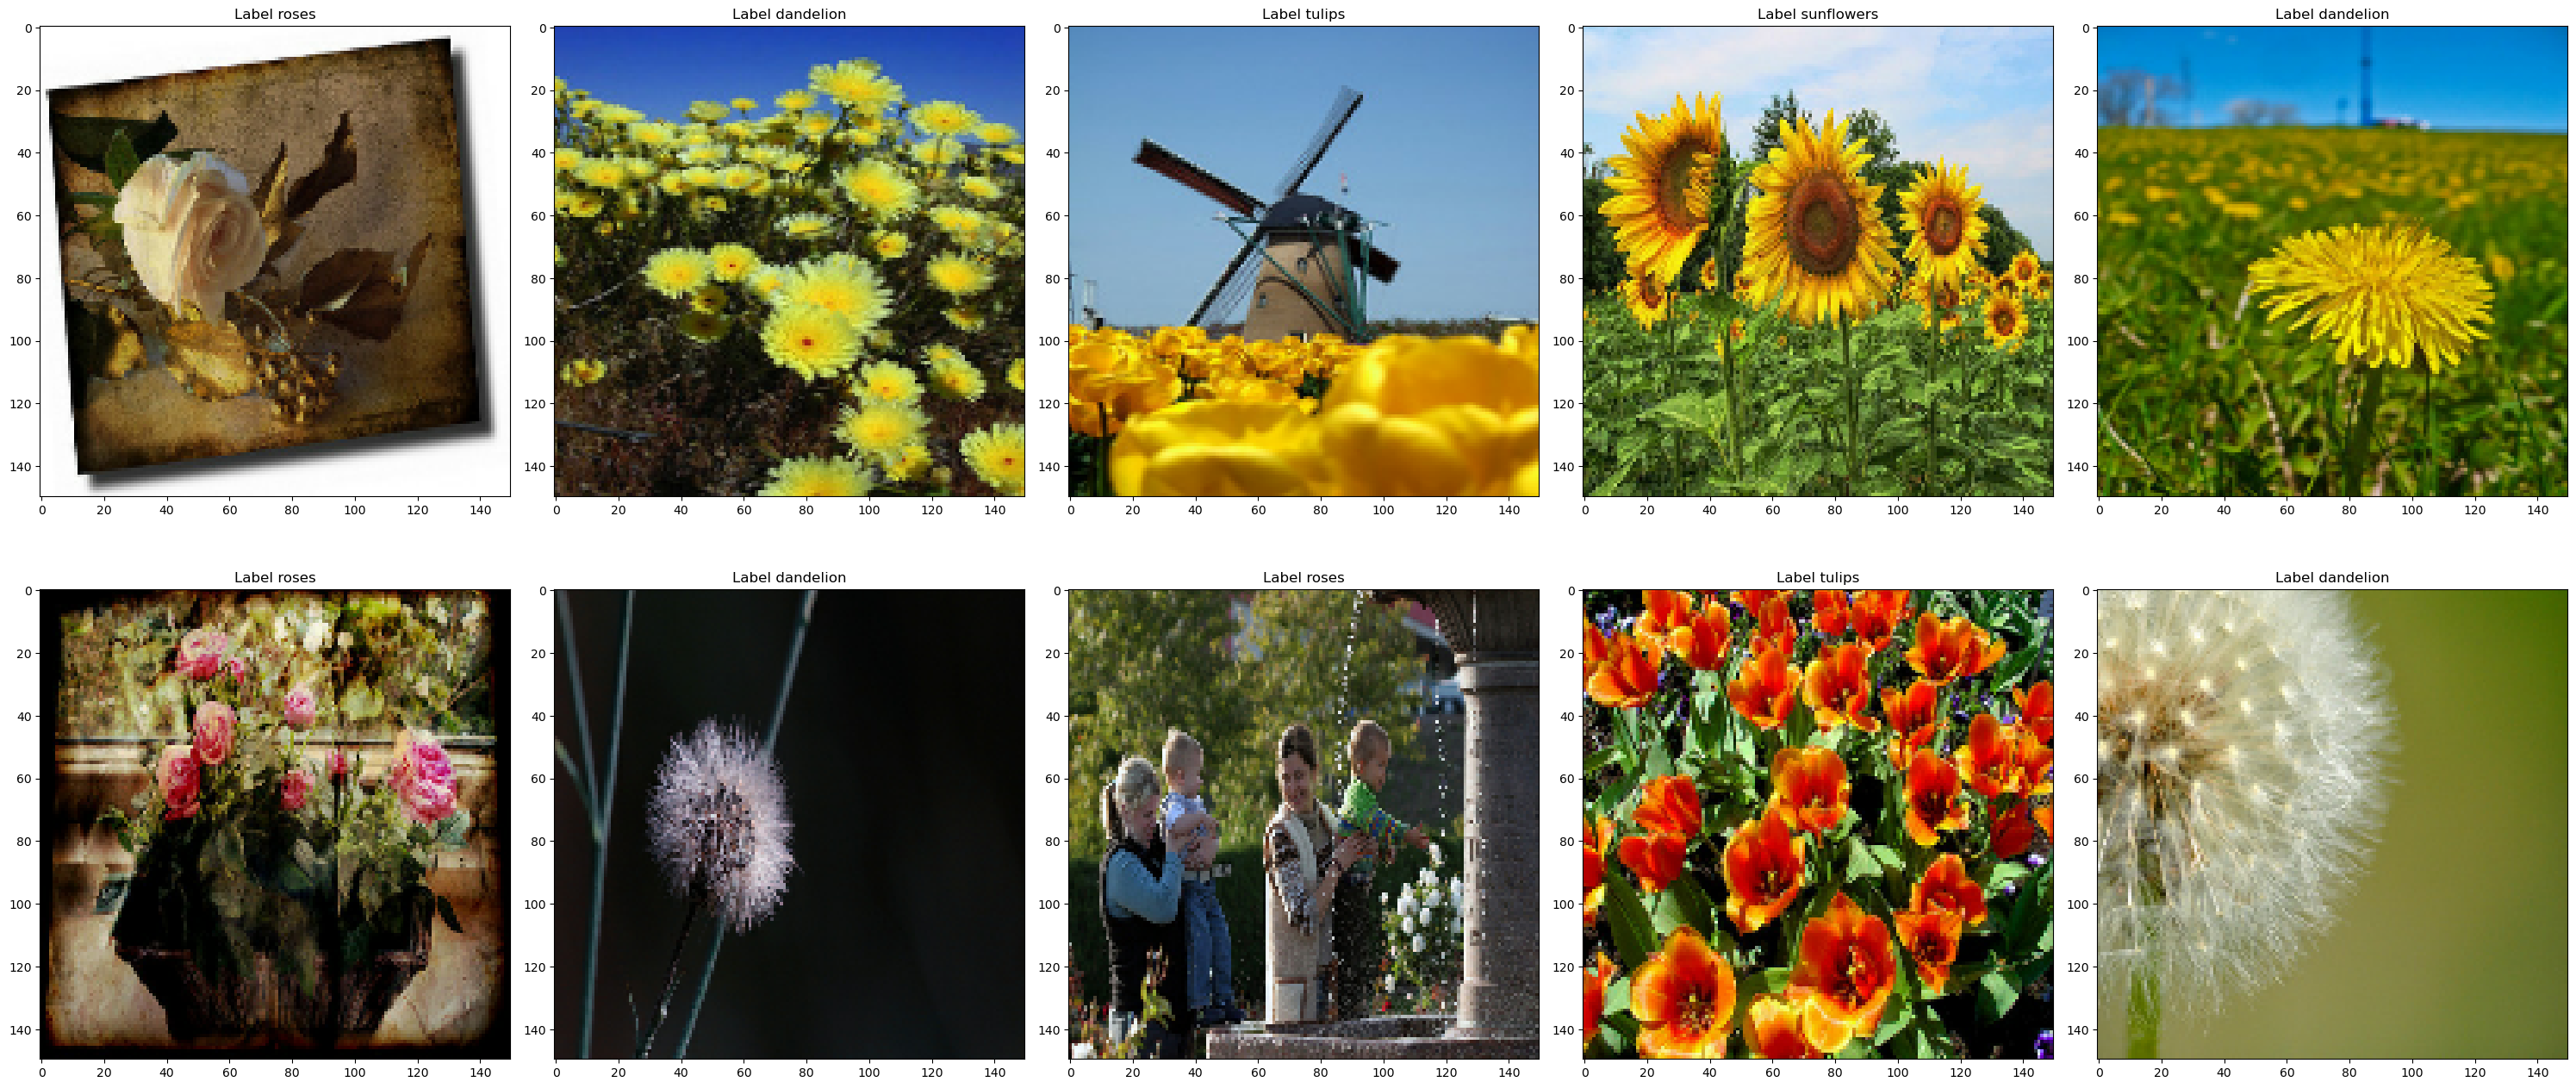

In [13]:
plt.rcParams["figure.figsize"] = [30, 15]
plt.rcParams["figure.autolayout"] = True

counter = 0
for image, label in zip(train_images, train_labels):
  plt.subplot(2, 5, counter+1)
  plt.imshow(image.astype("uint8"))
  label_name = class_names[np.where(label==1)[0][0]]
  plt.title('Label {}'.format(label_name))
  counter += 1
  if counter == 10:
    break

### Rescale the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

We can rescale values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling` in the model definition itself.

In [14]:
layers.Rescaling(1./255)

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [15]:

model = Sequential([
  layers.Rescaling(1./255, input_shape=(HEIGHT, WIDTH, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),

  layers.Dense(num_classes, name="outputs", activation='softmax')
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `categorical_crossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [16]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

One can pass other built-in metrics or pass their own metric function.

**Exercise** pass other [metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) and run the plot below. Modify the plots to visualize the other metrics.

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

### Train the model

* minimize **loss** on **training** dataset
* monitor **metrics** on **validation** dataset

![](https://drive.google.com/uc?export=view&id=1AH3JCmgoFGD_3AqyG8M9SNZ29040RVtL)



**Gradient Descent**

* $\theta_{t+1} = \theta_t - \alpha\nabla_\theta L_{\theta}(\underbrace{\{x_i,y_i\}}_{\textrm{all observations}})$

* decreases loss at each step
* requires calculating a gradient over the whole dataset


**Stochastic Gradient Descent**

* $\theta_{t+1} = \theta_t - \alpha\nabla_\theta L_{\theta}(\underbrace{\{x_i,y_i\}}_{\textrm{single random observation}})$

* eventually decreases loss (could be jumpy)
* cheap gradient calculation



**Mini-batch Gradient Descent**

* $\theta_{t+1} = \theta_t - \alpha\nabla_\theta L_{\theta}(\underbrace{\{x_i,y_i\}}_{\textrm{random batch of obsevations}})$

* compromise!


**Iteration:** the weights are updated based on a new batch

**Epoch:** the algorithm iterates over all batches (full training dataset)

![epochs_image](https://drive.google.com/uc?export=view&id=1Yd_l-z-PGCr7v0EwEyCWzcWBG_BoLZsX)

Image Source: [Thanapol et. al. ](https://www.mdpi.com/2076-3417/14/6/2349)

Mini-batch stochastic gradient descent is critical in being able to train huge networks on large datasets since we never have to load the whole dataset at one time! **Batch size** should allow to fit individual batch into memory and have sample big enough so weight updates and validation metrics are not too noisy.

**Early Stopping:** We set the max number of epochs to 50 in the `Model.fit` method, but we will also set an early stopping criterion which will monitor how the algorithm performs on the validation set, and if there is no significant improvement, the algorithm will stop.

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [19]:
%%time
epochs=50
history = model.fit(
  train_images,
  train_labels,
  validation_split=0.2,
  #shuffle=False,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

Epoch 1/50
74/74 [==============================] - 6s 22ms/step - loss: 1.2826 - accuracy: 0.4485 - val_loss: 1.2840 - val_accuracy: 0.4762
Epoch 2/50
74/74 [==============================] - 1s 15ms/step - loss: 1.0141 - accuracy: 0.5975 - val_loss: 1.1262 - val_accuracy: 0.5527
Epoch 3/50
74/74 [==============================] - 1s 15ms/step - loss: 0.8612 - accuracy: 0.6682 - val_loss: 1.0383 - val_accuracy: 0.6003
Epoch 4/50
74/74 [==============================] - 1s 15ms/step - loss: 0.6803 - accuracy: 0.7406 - val_loss: 0.9884 - val_accuracy: 0.6241
Epoch 5/50
74/74 [==============================] - 1s 15ms/step - loss: 0.4784 - accuracy: 0.8309 - val_loss: 1.0995 - val_accuracy: 0.6173
Epoch 6/50
74/74 [==============================] - 1s 15ms/step - loss: 0.3119 - accuracy: 0.8982 - val_loss: 1.1664 - val_accuracy: 0.6548
Epoch 7/50
74/74 [==============================] - 1s 15ms/step - loss: 0.1966 - accuracy: 0.9357 - val_loss: 1.4682 - val_accuracy: 0.6088
Epoch 8/50
74

**Warning!** If you run the fit command twice the model will continue to update the existing model, unless you rerun the model definition command.

We observe that

* the training set accuracy is almost 1
* the validation set accuracy is around ~0.6.

### Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

In [20]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

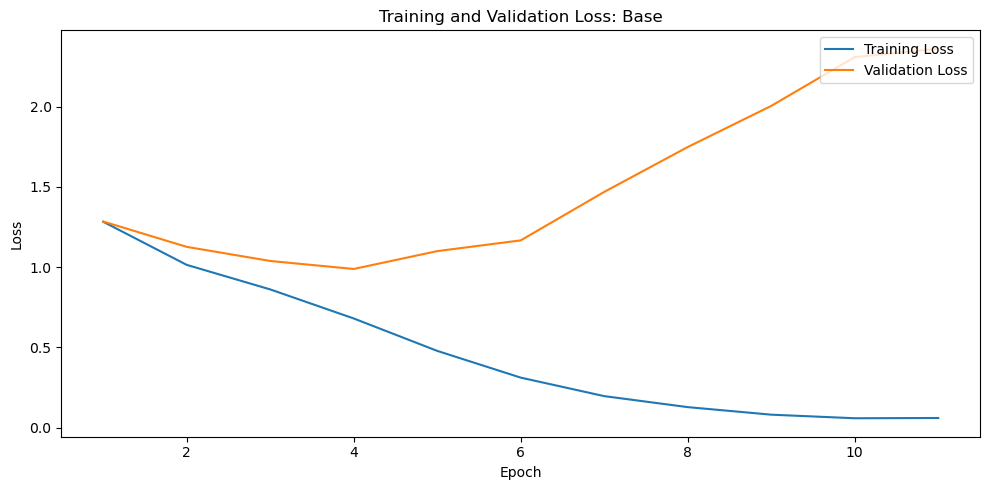

Text(0, 0.5, 'Accuracy')

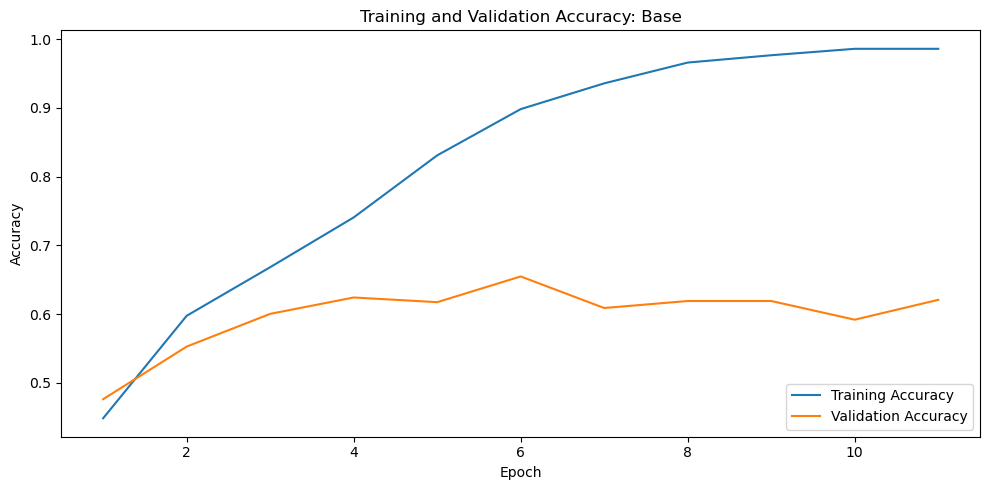

In [21]:
# accuracy metrics at each iteration are stored in the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Base')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Base')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.


### Overfitting!

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process and we will discuss those below.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

![image](https://raw.githubusercontent.com/mohcinemadkour/mohcinemadkour.github.io/master/images/dropout/1.gif)

Image from [mohcinemadkour.github.io](https://mohcinemadkour.github.io/posts/2020/04/Deep%20Learning%20Regularization/)



Create a new neural network with `tf.keras.layers.Dropout`.

In [22]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),

  layers.Dense(num_classes, name="outputs", activation='softmax')
])

In [23]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
%%time
epochs=50
history = model.fit(
  train_images,
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

Epoch 1/50


2024-05-08 11:51:41.431381: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


74/74 [==============================] - 4s 25ms/step - loss: 1.5955 - accuracy: 0.2981 - val_loss: 1.4600 - val_accuracy: 0.4082
Epoch 2/50
74/74 [==============================] - 1s 19ms/step - loss: 1.2896 - accuracy: 0.4434 - val_loss: 1.3318 - val_accuracy: 0.4099
Epoch 3/50
74/74 [==============================] - 1s 19ms/step - loss: 1.1644 - accuracy: 0.5068 - val_loss: 1.2783 - val_accuracy: 0.4388
Epoch 4/50
74/74 [==============================] - 1s 19ms/step - loss: 1.0999 - accuracy: 0.5315 - val_loss: 1.2376 - val_accuracy: 0.4439
Epoch 5/50
74/74 [==============================] - 1s 19ms/step - loss: 1.0497 - accuracy: 0.5643 - val_loss: 1.2110 - val_accuracy: 0.4949
Epoch 6/50
74/74 [==============================] - 1s 19ms/step - loss: 1.0064 - accuracy: 0.5903 - val_loss: 1.1612 - val_accuracy: 0.5170
Epoch 7/50
74/74 [==============================] - 1s 19ms/step - loss: 0.9723 - accuracy: 0.6201 - val_loss: 1.1476 - val_accuracy: 0.4983
Epoch 8/50
74/74 [======

* The trainining accuracy is lower!

* The validation accuracy ~ 67%.

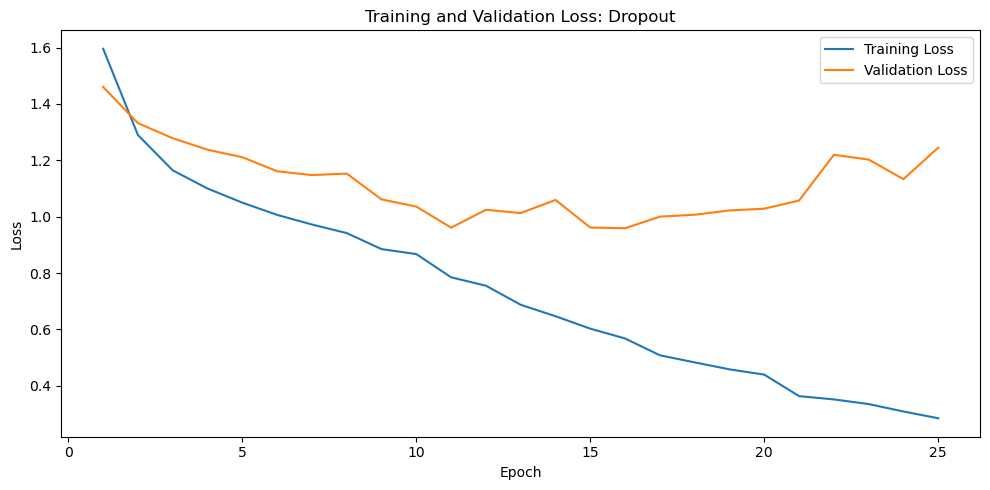

Text(0, 0.5, 'Accuracy')

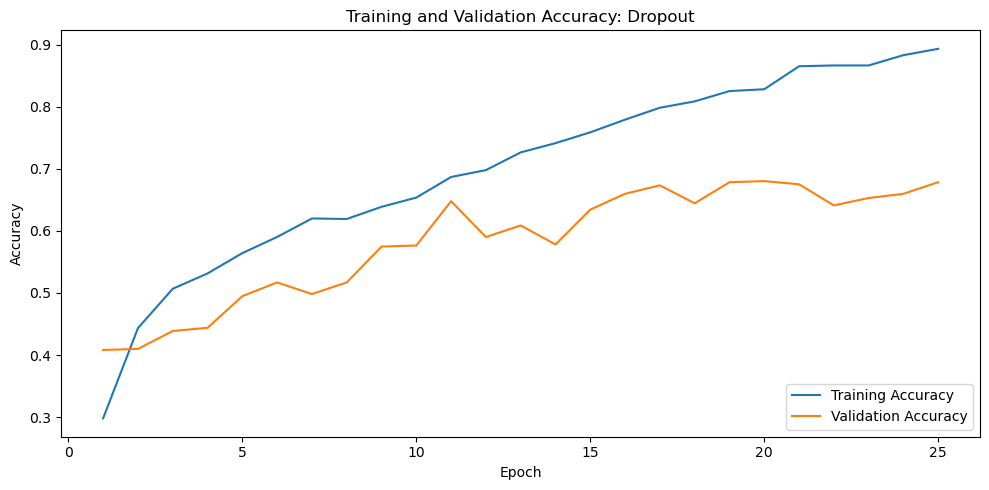

In [25]:
# accuracy metrics at each iteration are stored in the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Dropout')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

## Data Augmentation

[Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

Visualize a few augmented examples by applying data augmentation to the same image several times:

In [26]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=train_images[0,:,:,:].shape),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

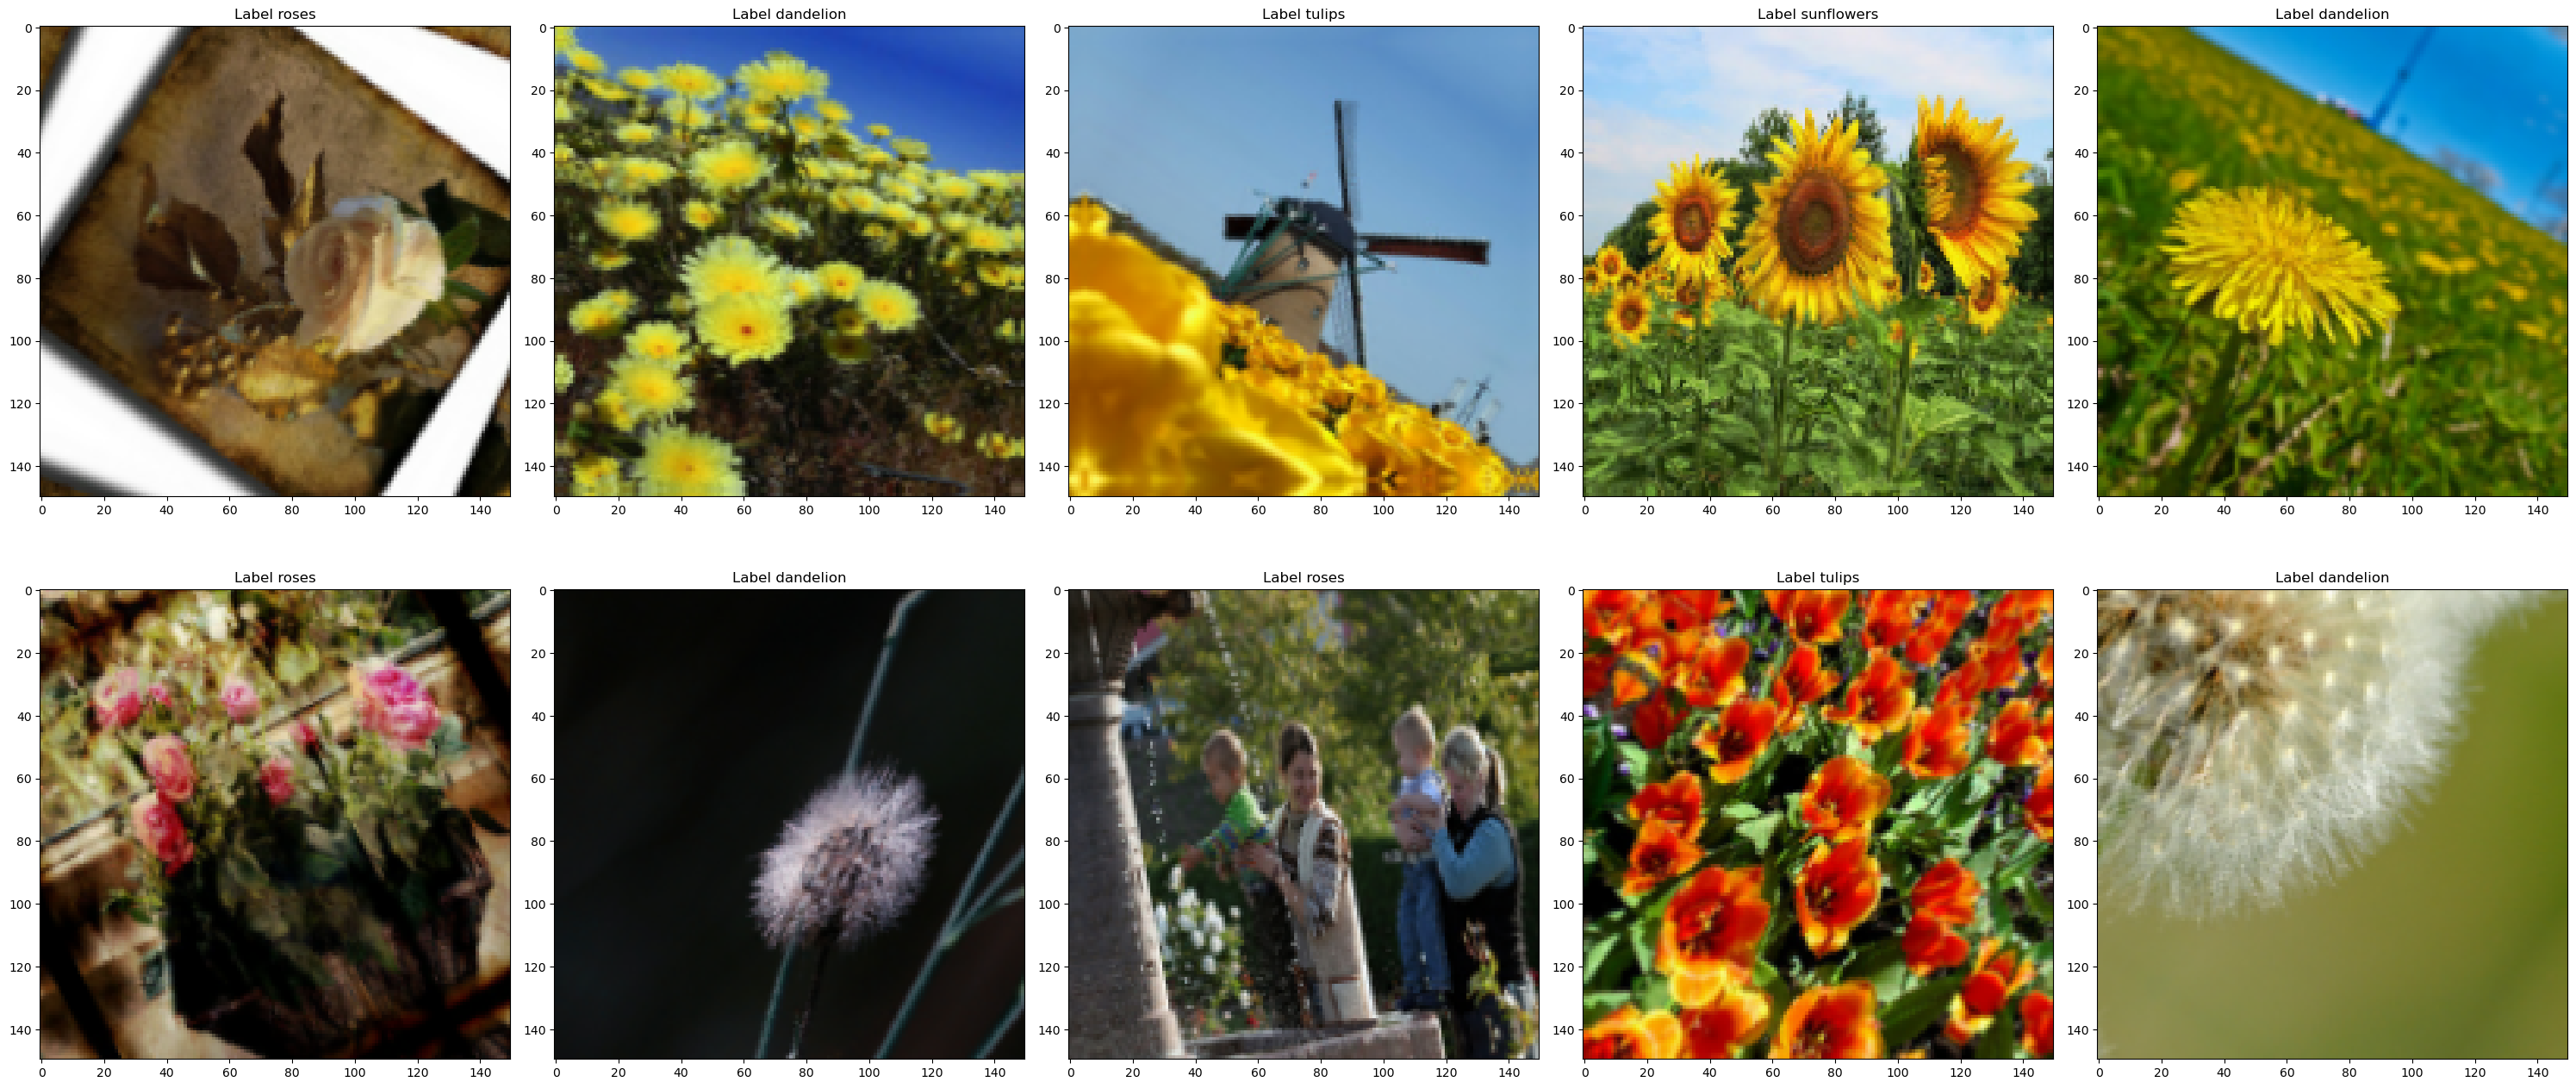

In [27]:
plt.rcParams["figure.figsize"] = [30, 15]
plt.rcParams["figure.autolayout"] = True

counter = 0
for image, label in zip(train_images, train_labels):
  plt.subplot(2, 5, counter+1)
  plt.imshow(data_augmentation(np.reshape(image, (1, HEIGHT, WIDTH, 3))).numpy().astype('uint8').squeeze())
  label_name = class_names[np.where(label==1)[0][0]]
  plt.title('Label {}'.format(label_name))
  counter += 1
  if counter == 10:
    break

We will add data augmentation to your model before training in the next step.

In [28]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),

  layers.Dense(num_classes, name="outputs", activation='softmax')
])

In [29]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
%%time
epochs=50
history = model.fit(
  train_images,
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

Epoch 1/50


2024-05-08 11:52:23.342977: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


74/74 [==============================] - 4s 26ms/step - loss: 1.7525 - accuracy: 0.2394 - val_loss: 1.6056 - val_accuracy: 0.2160
Epoch 2/50
74/74 [==============================] - 2s 21ms/step - loss: 1.5320 - accuracy: 0.2977 - val_loss: 1.4658 - val_accuracy: 0.3299
Epoch 3/50
74/74 [==============================] - 2s 21ms/step - loss: 1.3151 - accuracy: 0.4212 - val_loss: 1.3044 - val_accuracy: 0.4269
Epoch 4/50
74/74 [==============================] - 2s 21ms/step - loss: 1.2237 - accuracy: 0.4685 - val_loss: 1.2304 - val_accuracy: 0.4949
Epoch 5/50
74/74 [==============================] - 2s 21ms/step - loss: 1.1781 - accuracy: 0.5149 - val_loss: 1.2675 - val_accuracy: 0.4575
Epoch 6/50
74/74 [==============================] - 2s 21ms/step - loss: 1.1246 - accuracy: 0.5234 - val_loss: 1.1781 - val_accuracy: 0.5119
Epoch 7/50
74/74 [==============================] - 2s 20ms/step - loss: 1.1094 - accuracy: 0.5481 - val_loss: 1.1713 - val_accuracy: 0.5561
Epoch 8/50
74/74 [======

We observe that:
* training accuracy is ~.76
* validation accuracy is ~.73

In [31]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

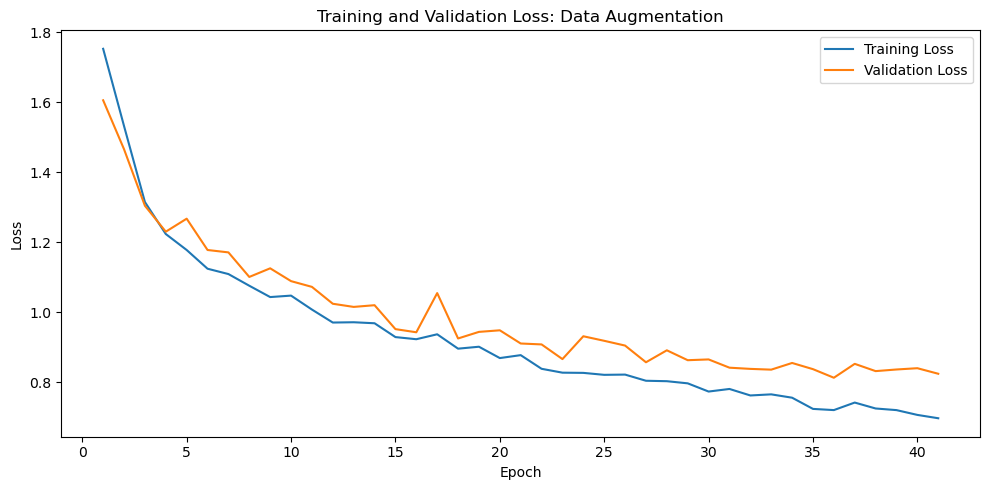

Text(0, 0.5, 'Accuracy')

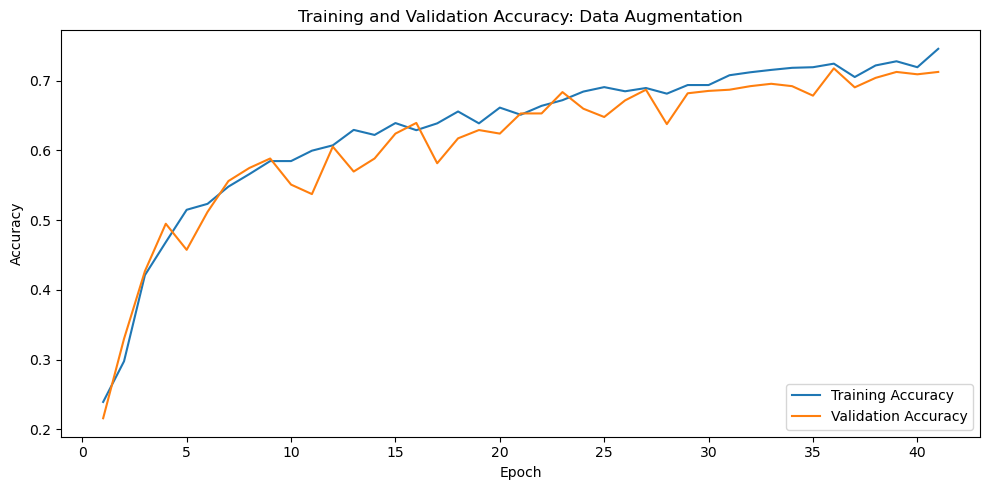

In [32]:
# accuracy metrics at each iteration are stored in the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Data Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Data Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

The training and validation behavior start to look more similar!

**Warning!** When doing data augmentation make sure augmented derivatives from the same image do not appear both in your train and validation datasets!

**Exercise:** Change some of the random transformation parameters and check if there is difference in performance.

**Exercise:** What other data augmentation techniques can be useful for this problem? Check if they are provided in [Keras](https://keras.io/api/layers/preprocessing_layers/image_augmentation/).

## Transfer Learning

Convolutional Neural Networks can be good feature extractors, i.e. a model trained on one dataset can turn out to be good at extracting useful features from another dataset. This allows deep learning methods to leverage large training sets and be able to generalize to situations where training data can be scarce.

* predict with a pretrained model on new data (zero-shot learning)
* extract features with a pretrained model and use them to train a shallow classifier on new data
* fine-tune the trained model to the new data by training with a small learning rate
* retrain the full model using the pre-trained model weights as initializers

As usual, we will have to evaluate the performance!

![TransferLearning](https://drive.google.com/uc?export=view&id=1QF9-eDrTkMouYJdU4k1qCklT3pLCI61u)

image src = https://www.slideshare.net/xavigiro/transfer-learning-d2l4-insightdcu-machine-learning-workshop-2017

![transfer_learning_chart](https://i.stack.imgur.com/RTKux.png)

### Frozen Pretrained Weights


Procedure:

* load and initialize a pretrained model
* remove the top layer
* freeze the weights of the pretrained model
* add a top layer(s) linking to our classes
* train the model

We will use a rather popular architecture VGG16 trained on the huge [Imagenet](https://www.image-net.org/) Dataset.


In [33]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
pretrained_model = VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, 3))
pretrained_model.trainable = False ## Not trainable weights

Pretrained models have certain expectations of how the data should look like so that it can be used in the model. They have a corresponding [`preprocess_input`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input) model. Make sure you read on the operations in the preprocessing so that it makes sense for your data.

In [34]:
train_images_preprocessed = preprocess_input(train_images.copy()).shape

**Warning!** The `preprocess_input` function changes the input **in-place** hence we need to pass a copy of the images.  

In [35]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(128, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    pretrained_model,
    flatten_layer,
    dense_layer_1,
    prediction_layer
])

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               1048704   
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 15,764,037
Trainable params: 1,049,349
Non-trainable params: 14,714,688
_________________________________________________________________


In [37]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [38]:
%%time
epochs=50
history = model.fit(
  preprocess_input(train_images.copy()),
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

Epoch 1/50
74/74 [==============================] - 10s 95ms/step - loss: 3.5124 - accuracy: 0.7244 - val_loss: 1.1070 - val_accuracy: 0.7602
Epoch 2/50
74/74 [==============================] - 6s 76ms/step - loss: 0.2457 - accuracy: 0.9289 - val_loss: 0.9326 - val_accuracy: 0.8010
Epoch 3/50
74/74 [==============================] - 6s 77ms/step - loss: 0.0556 - accuracy: 0.9851 - val_loss: 0.9959 - val_accuracy: 0.8044
Epoch 4/50
74/74 [==============================] - 6s 76ms/step - loss: 0.0319 - accuracy: 0.9936 - val_loss: 1.0520 - val_accuracy: 0.8061
Epoch 5/50
74/74 [==============================] - 6s 76ms/step - loss: 0.0242 - accuracy: 0.9945 - val_loss: 1.0652 - val_accuracy: 0.8010
Epoch 6/50
74/74 [==============================] - 6s 76ms/step - loss: 0.0140 - accuracy: 0.9987 - val_loss: 1.0467 - val_accuracy: 0.8044
Epoch 7/50
74/74 [==============================] - 6s 76ms/step - loss: 0.0075 - accuracy: 0.9987 - val_loss: 1.0424 - val_accuracy: 0.8044
Epoch 8/50
7

* training accuracy is very high again: ~0.98
* validation accuracy is also high: 0.79

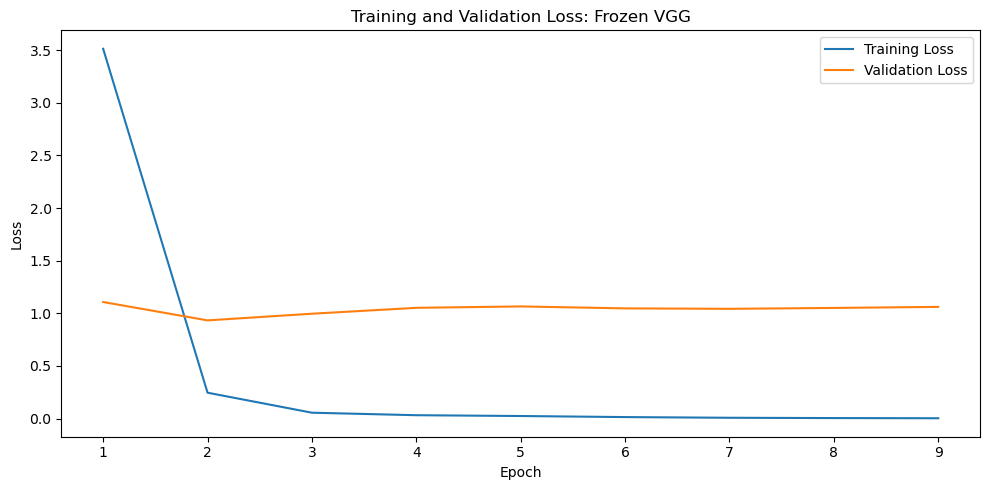

Text(0, 0.5, 'Accuracy')

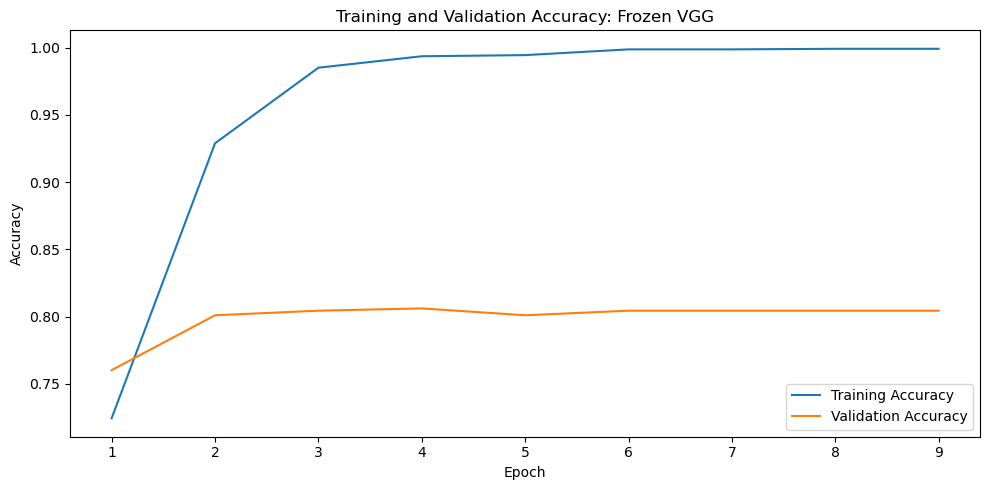

In [39]:
# accuracy metrics at each iteration are stored in the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Frozen VGG')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Frozen VGG')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

### Fine-Tune Pretrained Weights

Fine Tuning:
* Set the pretrained model to trainable (or some of its layers)
* Compile the model again
* Retrain with a small learning rate (0.0001)


In [40]:
pretrained_model.trainable = True

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [42]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               1048704   
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 15,764,037
Trainable params: 15,764,037
Non-trainable params: 0
_________________________________________________________________


In [43]:
%%time
epochs=50
history_fine = model.fit(
  preprocess_input(train_images.copy()),
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

Epoch 1/50
74/74 [==============================] - 25s 237ms/step - loss: 0.0507 - accuracy: 0.9868 - val_loss: 1.0467 - val_accuracy: 0.8078
Epoch 2/50
74/74 [==============================] - 15s 206ms/step - loss: 0.0361 - accuracy: 0.9919 - val_loss: 1.1625 - val_accuracy: 0.7993
Epoch 3/50
74/74 [==============================] - 15s 207ms/step - loss: 0.0264 - accuracy: 0.9949 - val_loss: 1.0129 - val_accuracy: 0.8180
Epoch 4/50
74/74 [==============================] - 15s 207ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 1.0762 - val_accuracy: 0.8146
Epoch 5/50
74/74 [==============================] - 15s 207ms/step - loss: 8.9140e-04 - accuracy: 1.0000 - val_loss: 1.1464 - val_accuracy: 0.8197
Epoch 6/50
74/74 [==============================] - 15s 207ms/step - loss: 4.1623e-04 - accuracy: 1.0000 - val_loss: 1.1622 - val_accuracy: 0.8248
Epoch 7/50
74/74 [==============================] - 15s 207ms/step - loss: 3.0129e-04 - accuracy: 1.0000 - val_loss: 1.1786 - val_accu

In [44]:
# accuracy metrics at each iteration are stored in the history variable
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

range(1, 25)


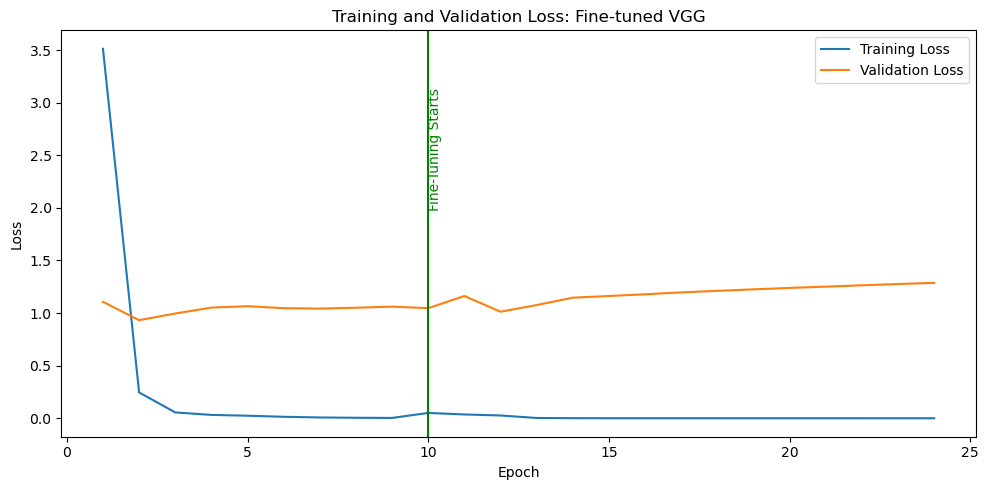

Text(0, 0.5, 'Accuracy')

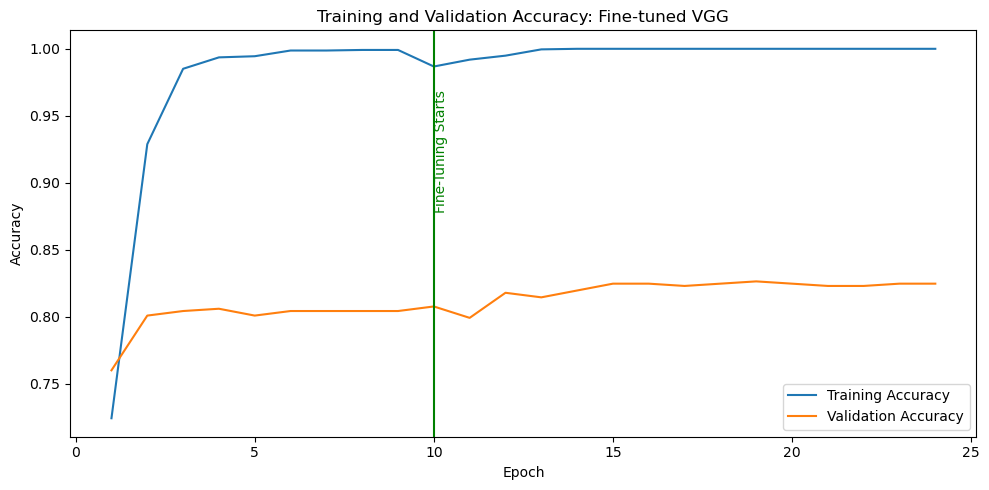

In [67]:
epochs_range = range(1, len(history.history['loss'])+1)
print(epochs_range)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.axvline(x = len(history.history['loss']) - len(history_fine.history['loss'])+1, color = 'g',)
plt.text(len(history.history['loss']) - len(history_fine.history['loss'])+1,2,'Fine-Tuning Starts',rotation=90, color='g')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Fine-tuned VGG')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.axvline(x = len(history.history['loss']) - len(history_fine.history['loss'])+1, color = 'g')
plt.text(len(history.history['loss']) - len(history_fine.history['loss'])+1,0.88,'Fine-Tuning Starts',rotation=90, color='g')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Fine-tuned VGG')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

**Exercise:** Retrain full model starting from the imagenet weights (making all weights trainable).

**Exercise:** Retrain the last 10 layers of the pretrained model + the top layer.

Pretrained models can be found:
* within the [keras library](https://keras.io/api/applications/)
* on [tensorflow(kaggle) hub](https://www.tensorflow.org/hub)
* [HuggingFace](https://huggingface.co/models)
* domain-specific challenges
* colleagues


## Save Model


We are saving the model architecture, weights, and training configuration. We can restart training from it!

In [68]:
model.save("flowers_model.keras")

## Too Many Experiments!

[TensorBoard](https://www.tensorflow.org/tensorboard) is a tool to visualize experiment performance. It can also visualize results during training. There are many other options but tensorboard is open source and can run locally and integrates with notebooks.

In [47]:
# add this additional callback
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

To run tensorboard in a notebook:

In [48]:
%load_ext tensorboard

%tensorboard --logdir logs/fit

## Hyperparameter Tuning

We can see how there are many parameters that can be tuned in a NN model:

* network parameters
* optimization parameters


A natural question is whether we can automate the process of testing different values. There are several approaches to that:

* Grid Search
* Random Search
* Bayesian Optimization

There are also tools to achieve that in Keras:

[keras tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

[HParams Dashboard](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams)

**Warning!** Automatic hyperparameter search can be very prone to overtuning. It can be useful when there is a large amount of training data (which will also allow for plenty validation data). However, when large training datasets are available, the models may work well without too much tuning.

## Predict on new data

Use the selected model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [49]:
# convert to numpy arrays
test_images, test_labels = zip(*list(test_ds.unbatch()))
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [50]:
predictions = model.predict(test_images)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

23/23 [==============================] - 3s 136ms/step
This image most likely belongs to dandelion with a 40.46 percent confidence.


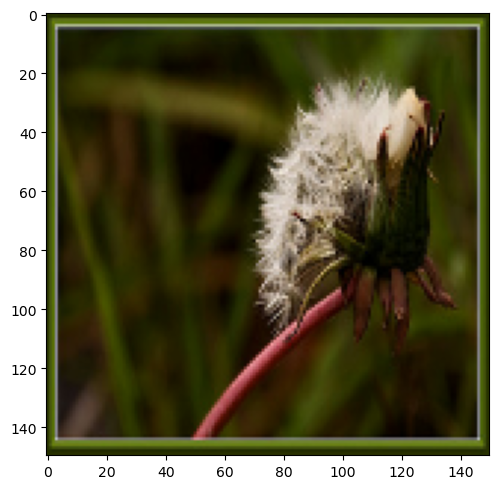

In [51]:
plt.imshow(test_images[0,:,:,:]/255.)

In [71]:
# once you are ready to evaluate on the test data you can run this command
# Warning: run this once to report the results, do not tune/select the model based on the test data!

# loss, acc = model.evaluate(test_images, test_labels)

### Go Out And Collect More Flowers!